# Training a *convnet* from Scratch on a Small Dataset

Having to train an image-classification model using very little data is a common situation, which you’ll likely encounter in practice if you ever do computer vision in a professional context. In this section, we’ll review one basic strategy to tackle this problem: training a new model from scratch using what little data you have. We’ll start by naively training a small *convnet* without any regularization. At that point, the main issue will be overfitting. Then we’ll introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision.

Once the data we are going to use is downloaded from `https://www.microsoft.com/en-us/download/details.aspx?id=54765`, we are going to choose a small part of it to train our *convnet*.

In [19]:
# Copying images to training, validation, and test directories
import os, shutil, pathlib

original_dir = pathlib.Path("/mnt/0A2AAC152AABFBB7/sideProjects/data/kaggleCatsDogs/train")
new_base_dir = pathlib.Path("/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/data/cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = os.path.join(new_base_dir, subset_name, category)
        print(dir)
        if not os.path.exists(dir):
            os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=os.path.join(original_dir, fname), 
                            dst=os.path.join(dir, fname))

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/data/cats_vs_dogs_small/train/cat
/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/data/cats_vs_dogs_small/train/dog
/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/data/cats_vs_dogs_small/validation/cat
/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/data/cats_vs_dogs_small/validation/dog
/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/data/cats_vs_dogs_small/test/cat
/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/data/cats_vs_dogs_small/test/dog


We will reuse the same general model structure you saw in the first example: the convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. But because we’re dealing with bigger images and a more complex problem, we’ll make our model larger, accordingly: it will have two more `Conv2D` and `MaxPooling2D` stages. This serves both to augment the capacity of the model and to further reduce the size of the feature maps so they aren’t overly large when we reach the `Flatten` layer.

Because we’re looking at a binary-classification problem, we’ll end the model with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will encode the probability that the model is looking at one class or the other. One last small difference: we will start the model with a `Rescaling` layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range.

In [20]:
# Instantiating a small convnet for dogs vs. cats classification
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

For the compilation step, we’ll go with the `RMSprop` optimizer, as usual. Because we ended the model with a single sigmoid unit, we’ll use binary crossentropy as the loss function.

In [21]:
# Configuring the model for training
model.compile(
    loss     ="binary_crossentropy",
    optimizer="rmsprop",
    metrics  =["accuracy"]
)

As you know by now, data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model. Currently, the data sits on a drive as `JPEG` files, so the steps for getting it into the model are roughly as follows:
1. Read the picture files;
2. Decode the JPEG content to RGB grids of pixels;
3. Convert these into floating-point tensors;
4. Resize them to a shared size (we’ll use 180 × 180);
5. Pack them into batches (we’ll use batches of 32 images).

Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function `image_dataset_from_directory()`, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors.

In [22]:
# Using image_dataset_from_directory to read images

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [23]:
# Fitting the model using a Dataset

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath      ="/mnt/0A2AAC152AABFBB7/sideProjects/introCompVision/savedModels/convnet_from_scratch.keras",
        save_best_only=True,
        monitor       ="val_loss"
    )
]
history = model.fit(
    train_dataset,
    epochs         =30,
    validation_data=validation_dataset,
    callbacks      =callbacks
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 823ms/step - accuracy: 0.5211 - loss: 0.7267 - val_accuracy: 0.5000 - val_loss: 0.6919
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 821ms/step - accuracy: 0.5146 - loss: 0.6928 - val_accuracy: 0.6210 - val_loss: 0.6899
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 793ms/step - accuracy: 0.5230 - loss: 0.6927 - val_accuracy: 0.5270 - val_loss: 0.6818
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 887ms/step - accuracy: 0.6003 - loss: 0.6689 - val_accuracy: 0.6210 - val_loss: 0.6435
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 826ms/step - accuracy: 0.6369 - loss: 0.6467 - val_accuracy: 0.6020 - val_loss: 0.6872
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 800ms/step - accuracy: 0.6544 - loss: 0.6085 - val_accuracy: 0.6870 - val_loss: 0.6020
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 813ms/step - accuracy: 0.7006 - loss: 0.5633 - val_accuracy: 0.6420 - val_loss: 0.6397
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 814ms/step - accuracy: 0.7422 - loss: 0.5218 - val_accu

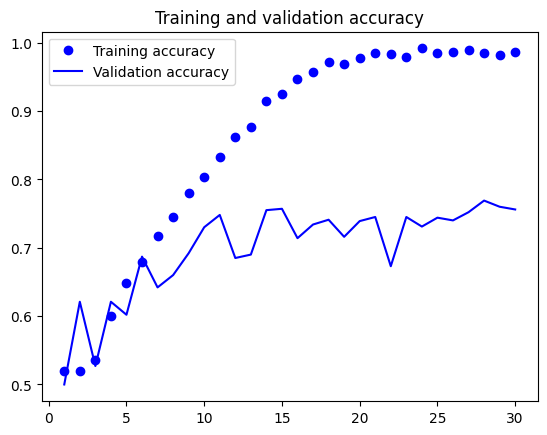

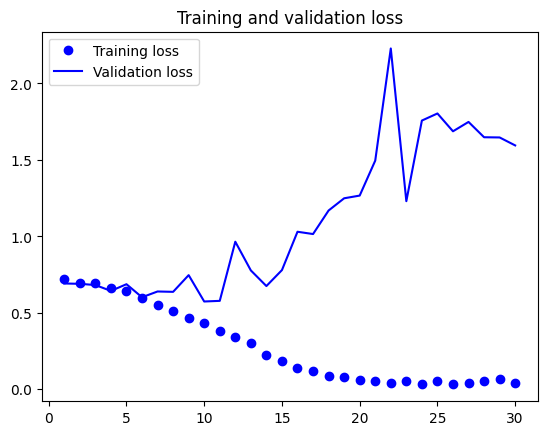

In [24]:
# Displaying curves of loss and accuracy during training

import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()